In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [2]:
all_xray_df = pd.read_csv('./data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('.', 'data', 'images*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]

all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

# since the dataset is very unbiased, we can resample it to be a more reasonable collection

Scans found: 112120 , Total Headers 112120
All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


In [3]:

# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(40000, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]

label_counts = 100*np.mean(all_xray_df[all_labels].values,0)

# Prepare Training Data
Here we split the data into training and validation sets and create a single vector (disease_vec) with the 0/1 outputs for the disease status (what the model will try and predict)

In [4]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [5]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 30000 validation 10000


# Create Data Generators
Here we make the data generators for loading and randomly transforming images

In [6]:
valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

C:\Users\bisedab\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\bisedab\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
from keras.preprocessing.image import ImageDataGenerator
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

Using TensorFlow backend.


In [9]:
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras import optimizers, callbacks, regularizers


def MakeMobileNetModel(IMG_SIZE, bs, channels=1):
    model = Sequential()
    base_model = MobileNet(input_shape =  (*IMG_SIZE, channels), #Need to define the shape here from IMG_SIZE
                                 include_top = False, weights = None)
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(len(all_labels), activation = 'sigmoid'))
    return model


def MakeResnetModel(IMG_SIZE, bs, channels=1):
    model = Sequential()
    base_model = InceptionResNetV2(input_shape =  (*IMG_SIZE, channels), #Need to define the shape here from IMG_SIZE
                                 include_top = False, weights = None)
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(len(all_labels), activation = 'sigmoid'))
    return model

def MakeVGGModel(IMG_SIZE, bs, channels=1):
    model = Sequential()
    base_model = VGG19(input_shape =  (*IMG_SIZE, channels), #Need to define the shape here from IMG_SIZE
                                 include_top = False, weights = None)
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(len(all_labels), activation = 'sigmoid'))
    return model

# Create Models and Load Weights

## Define Parameters

In [18]:
imageSize = (512, 512)
colorMode = 'rgb'
channels = 3
batchSize = 8

valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = 'newLabel', 
                         class_mode = 'categorical',
                        classes = all_labels,
                        target_size = imageSize,
                         color_mode = colorMode,
                        batch_size = batchSize) # we can use much larger batches for evaluation

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = 'newLabel', 
                         class_mode = 'categorical',
                        classes = all_labels,
                        target_size = imageSize,
                         color_mode = 'rgb',
                        batch_size = 9419))

Found 9419 validated image filenames belonging to 13 classes.
Found 9419 validated image filenames belonging to 13 classes.


In [35]:
def createROC(all_labels, test_Y, pred_Y, filename="roc.png"):
    aucScores = []
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    for (idx, c_label) in enumerate(all_labels):
        fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
        aucScores.append(auc(fpr,tpr))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    fig.savefig(filename)
    return aucScores

## MobileNet

In [17]:
mobilenet_model = MakeMobileNetModel(imageSize, batchSize, channels)
mobilenet_model.load_weights('xray_class_weights.best.hdf5')

In [24]:
mobilenet_preds = mobilenet_model.predict(test_X, batch_size = 64, verbose = True)

9419/9419 [==============================] - 40s 4ms/step


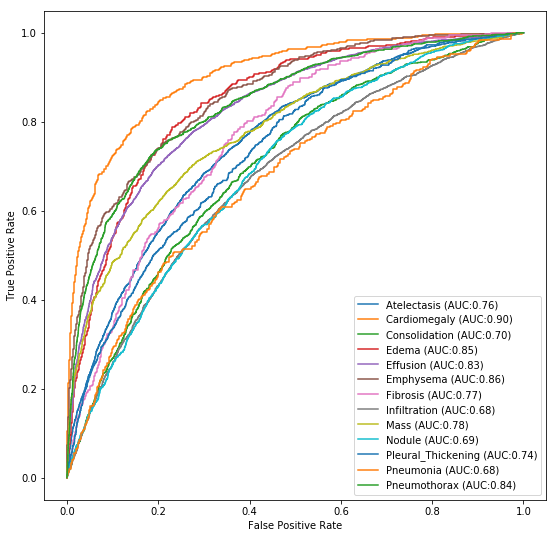

In [41]:
mobilenetAUC = createROC(all_labels, test_Y, mobilenet_preds, filename="mobilenet_roc.png")

## Resnet

In [26]:
resnet_model = MakeResnetModel(imageSize, batchSize, channels)
resnet_model.load_weights('xray_class_weights_resnet.best.hdf5')

In [27]:
resnet_preds = resnet_model.predict(test_X, batch_size = 64, verbose = True)

9419/9419 [==============================] - 142s 15ms/step


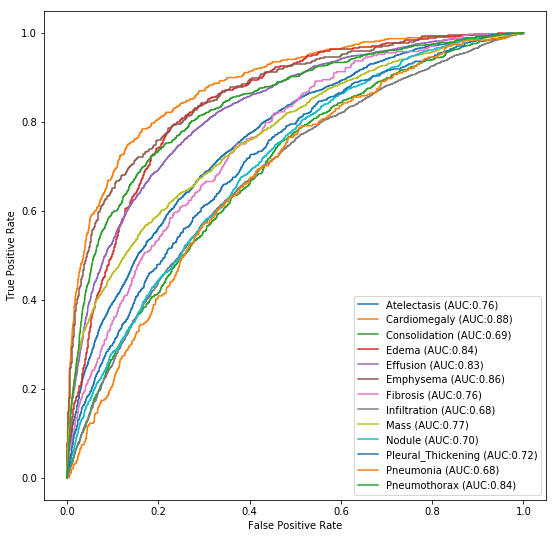

In [40]:
ResnetAUC = createROC(all_labels, test_Y, resnet_preds, filename="resnet_roc.png")

## VGG

In [29]:
vgg_model = MakeVGGModel(imageSize, batchSize, channels)
vgg_model.load_weights('xray_class_weights_vgg.best.hdf5')

In [47]:
vgg_preds = vgg_model.predict(test_X, batch_size = 32, verbose = True)

9419/9419 [==============================] - 126s 13ms/step


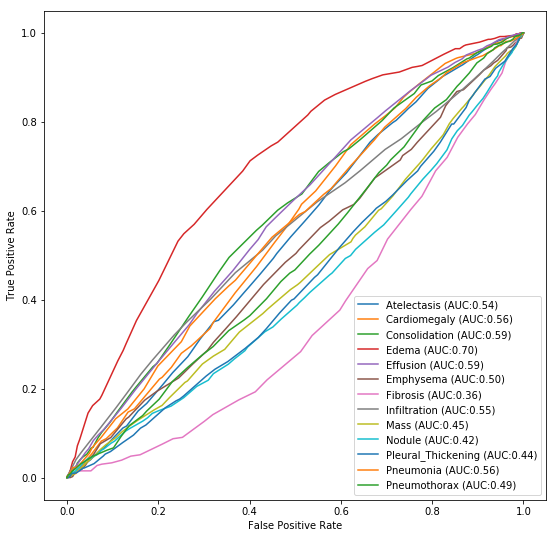

In [48]:
VGGAUC = createROC(all_labels, test_Y, vgg_preds, filename="vgg_roc.png")

# Ensemble Method

In [63]:
predictionList = [mobilenet_preds, resnet_preds, vgg_preds]

In [88]:
weightList = [0.5, 0.3, 0.2]

In [116]:
def MaxVoteEnsemble(predictionList):
    ensemble_preds = np.maximum(*predictionList)
    return ensemble_preds

def HardVoteEnsemble(predictionList):
    ensemble_preds = np.zeros(predictionList[0].shape)
    for pred in predictionList:
        ensemble_preds += np.rint(pred)
    
    ensemble_preds /= len(predictionList)

    return ensemble_preds

def SimpleAverageEnsemble(predictionList):
    ensemble_preds = np.zeros(predictionList[0].shape)
    for pred in predictionList:
        ensemble_preds += pred
    
    ensemble_preds /= len(predictionList)
    
    return ensemble_preds

def WeightedAverageEnsemble(predictionList, weightList):
    ensemble_preds = np.zeros(predictionList[0].shape)
    for pred, weight in zip(predictionList, weightList):
        ensemble_preds += pred*weight
    
    return ensemble_preds

In [117]:
max_vote_ensemble_preds = MaxVoteEnsemble(predictionList)
hard_vote_ensemble_preds = HardVoteEnsemble(predictionList)
simple_ensemble_preds = SimpleAverageEnsemble(predictionList)
weighted_ensemble_preds = WeightedAverageEnsemble(predictionList, weightList)

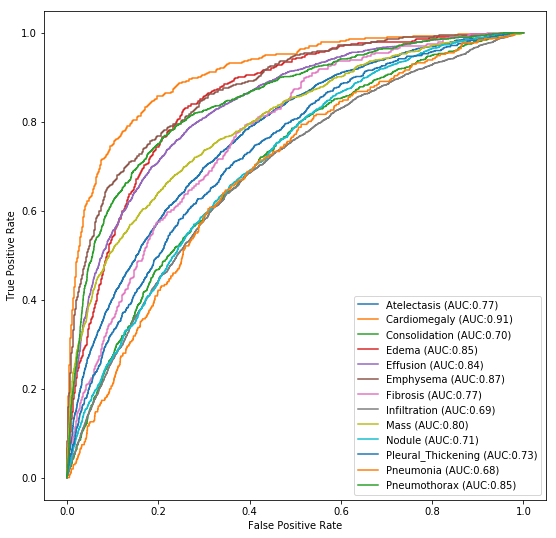

In [118]:
maxvoteensembleAUC = createROC(all_labels, test_Y, max_vote_ensemble_preds, filename="max_vote_ensemble_roc.png")

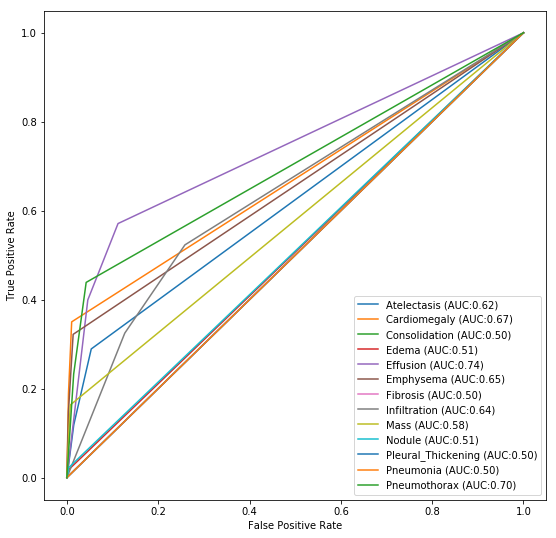

In [119]:
hardvoteensembleAUC = createROC(all_labels, test_Y, hard_vote_ensemble_preds, filename="hard_vote_ensemble_roc.png")

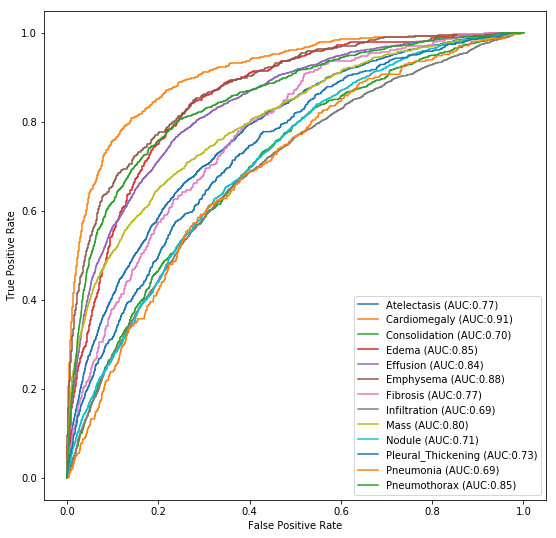

In [120]:
simpleensembleAUC = createROC(all_labels, test_Y, simple_ensemble_preds, filename="simple_ensemble_roc.png")

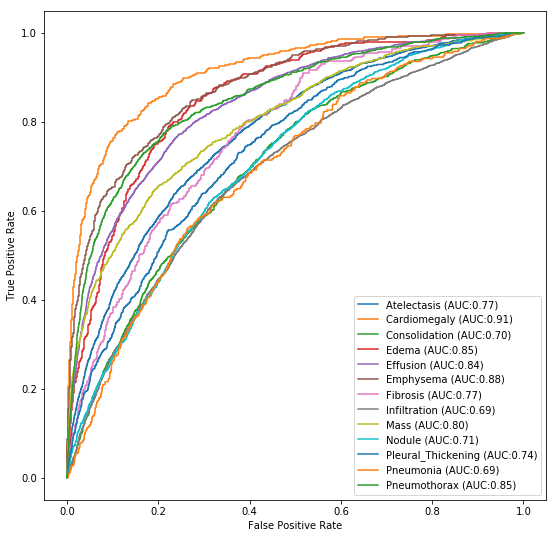

In [121]:
weightedensembleAUC = createROC(all_labels, test_Y, weighted_ensemble_preds, filename="weighted_ensemble_roc.png")

In [122]:
summaryDF = pd.DataFrame(
    {'Class':all_labels,
    'Mobilenet': mobilenetAUC,
    'Resnet': ResnetAUC,
    'VGG': VGGAUC,
    'Avg Ensemble': simpleensembleAUC,
    'Wght Avg Ensemble': weightedensembleAUC,
    'Hard Vote Ensemble': hardvoteensembleAUC,
    'Max Vote Ensemble': maxvoteensembleAUC}
)

In [123]:
summaryDF.round(3)

,Class,Mobilenet,Resnet,VGG,Avg Ensemble,Wght Avg Ensemble,Hard Vote Ensemble,Max Vote Ensemble
0,Atelectasis,0.757,0.762,0.538,0.773,0.773,0.619,0.769
1,Cardiomegaly,0.904,0.885,0.560,0.910,0.911,0.670,0.908
2,Consolidation,0.702,0.687,0.588,0.703,0.704,0.500,0.701
3,Edema,0.846,0.842,0.700,0.852,0.853,0.507,0.850
4,Effusion,0.830,0.827,0.586,0.838,0.838,0.739,0.836
5,Emphysema,0.860,0.864,0.495,0.876,0.877,0.655,0.873
6,Fibrosis,0.769,0.755,0.360,0.772,0.772,0.500,0.767
7,Infiltration,0.680,0.682,0.551,0.689,0.689,0.641,0.686
8,Mass,0.782,0.769,0.452,0.799,0.799,0.578,0.796
9,Nodule,0.695,0.702,0.421,0.709,0.708,0.509,0.706
